In [ ]:
%matplotlib inline

In [ ]:
import itertools
import os
import requests
import zipfile

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T

from io import BytesIO
from IPython.display import YouTubeVideo
from PIL import Image

## History

Object detection shares a similar history to image recognition.
They both currently use convolutional neural networks and both require large image datasets.
With convolutional neural networks, they share the common origina of the Neocognitron, LeNet, and AlexNet, but object detection was inspired by different methods that were used before the current era of neural networks.

There were two popular methods in the 2000s:


*   Lowe's scale-invariant feature transform (SIFT) method
*   Dalel and Trigg's historgram of oriented gradients (HOG)

They both use some type of convolutional features: a Gaussian is used in SIFT and a Gaussian or a Sobel operator are used in HOG.

The current methods are primarily convolutional neural network based.
They can be roughly classified into two types: single stage and two stage.
A single stage detector predicts an object and a bounding box for that object.
Two stage object detection extracts a region proposal (potential bounding boxes), then classifies these regions, e.g. does it have a car, a dog, a person, etc.

We'll be focusing on the single stage classifiers, in particular, the YOLO (You Only Look Once) class of models.


# Lakota AI Code Camp Lesson 03: Introduction to Object Detection

Object detection is a subfield of computer vision.
It is focused on detecting if an object is in an image and if it is in the image, where it's located.
Let's look at an example.

The following is the label of the image:

In [ ]:
object_dict = {
   "objects":[
      {
         "rectangle":{
            "x":730,
            "y":66,
            "w":135,
            "h":85
         },
         "object":"kitchen appliance",
         "confidence":0.501
      },
      {
         "rectangle":{
            "x":523,
            "y":377,
            "w":185,
            "h":46
         },
         "object":"computer keyboard",
         "confidence":0.51
      },
      {
         "rectangle":{
            "x":471,
            "y":218,
            "w":289,
            "h":226
         },
         "object":"Laptop",
         "confidence":0.85,
         "parent":{
            "object":"computer",
            "confidence":0.851
         }
      },
      {
         "rectangle":{
            "x":654,
            "y":0,
            "w":584,
            "h":473
         },
         "object":"person",
         "confidence":0.855
      }
   ],
   "requestId":"25018882-a494-4e64-8196-f627a35c1135",
   "metadata":{
      "height":473,
      "width":1260,
      "format":"Jpeg"
   },
   "modelVersion":"2021-05-01"
}

We are downloading an image from a website, then we are converting it into it an array of numbers

In [ ]:
img_src = "https://learn.microsoft.com/en-us/azure/cognitive-services/computer-vision/images/windows-kitchen.jpg"

resp = requests.get(img_src)

img = Image.open(BytesIO(resp.content))

img_array = np.asarray(img)

Images are typically stored in a 3 channel format.
In our case, the channels are red, green, and blue.
It is a combination of the different intensities of red, green, and blue in each matrix.

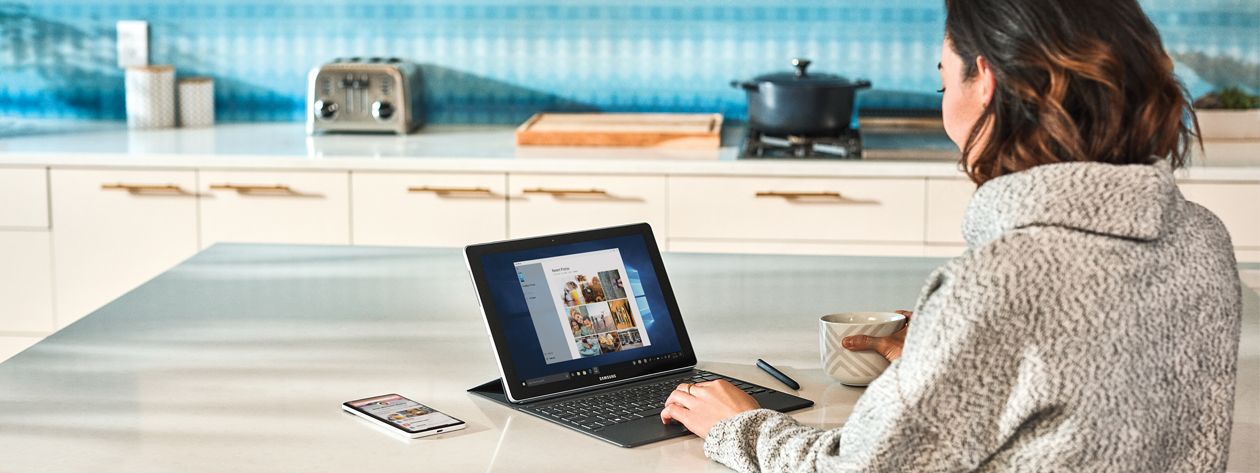

In [ ]:
img

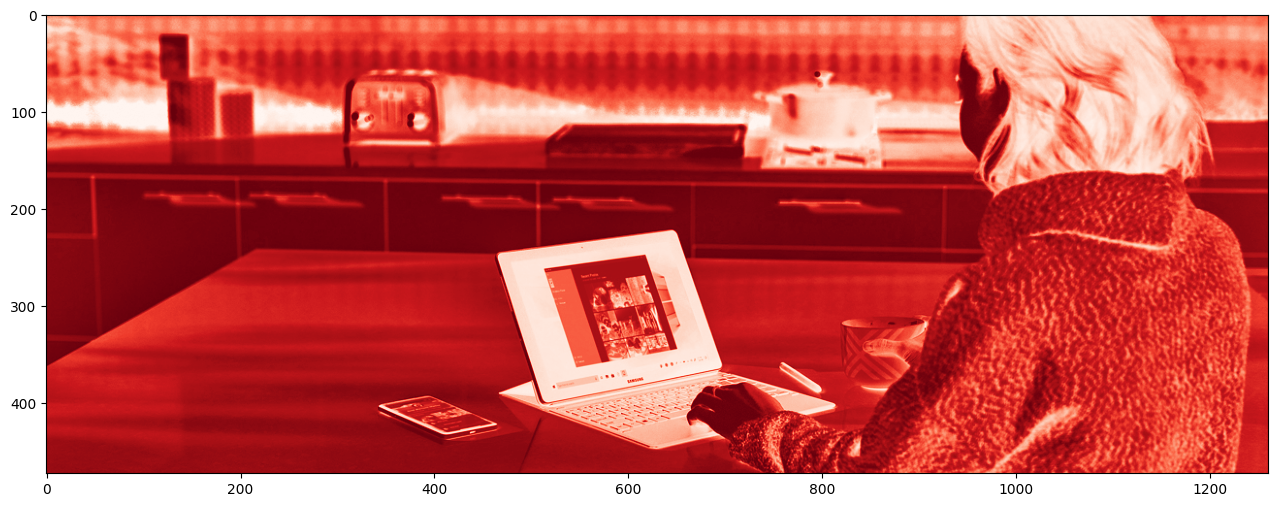

In [ ]:
plt.figure(figsize=(473 / 30, 1260 / 30))
plt.imshow(img_array[:,:,0], cmap='Reds')
plt.show()

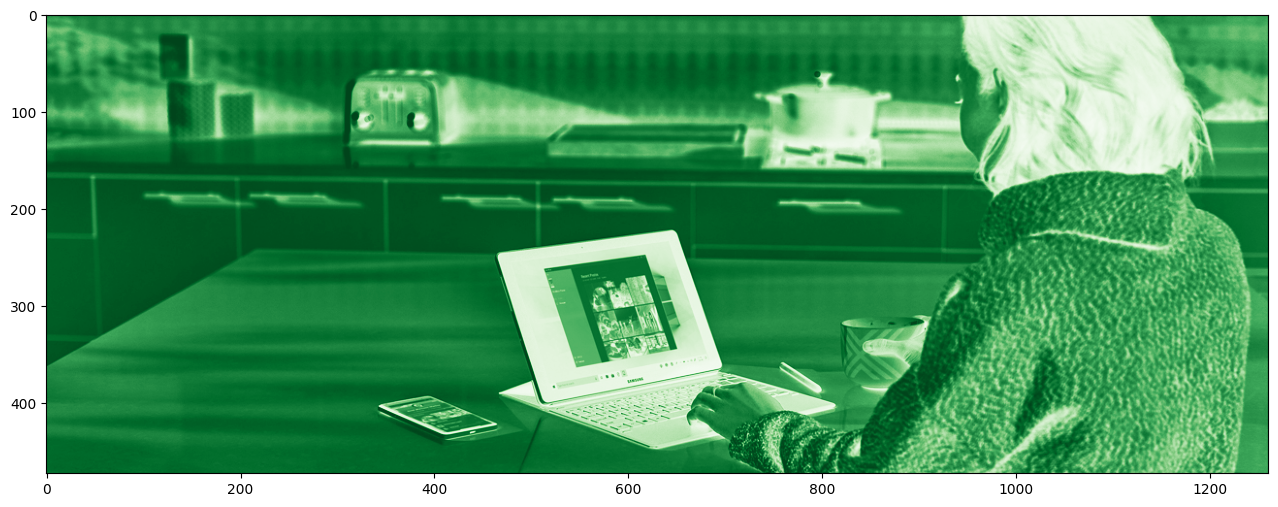

In [ ]:
plt.figure(figsize=(473 / 30, 1260 / 30))
plt.imshow(img_array[:,:,1], cmap='Greens')
plt.show()

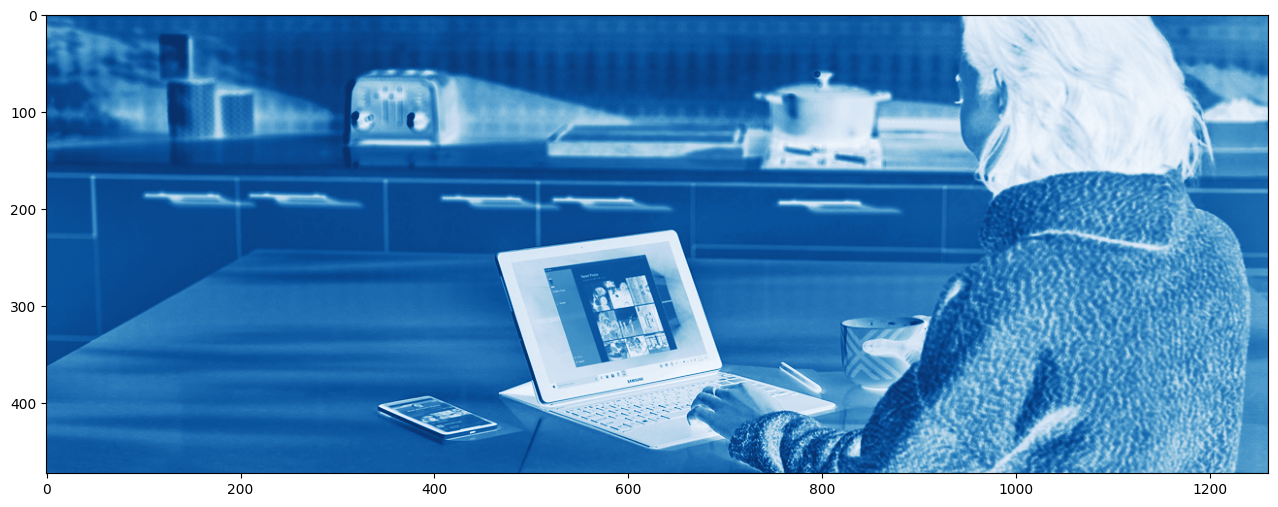

In [ ]:
plt.figure(figsize=(473 / 30, 1260 / 30))
plt.imshow(img_array[:,:,2], cmap='Blues')
plt.show()

Now, we display the label of the image on the image:

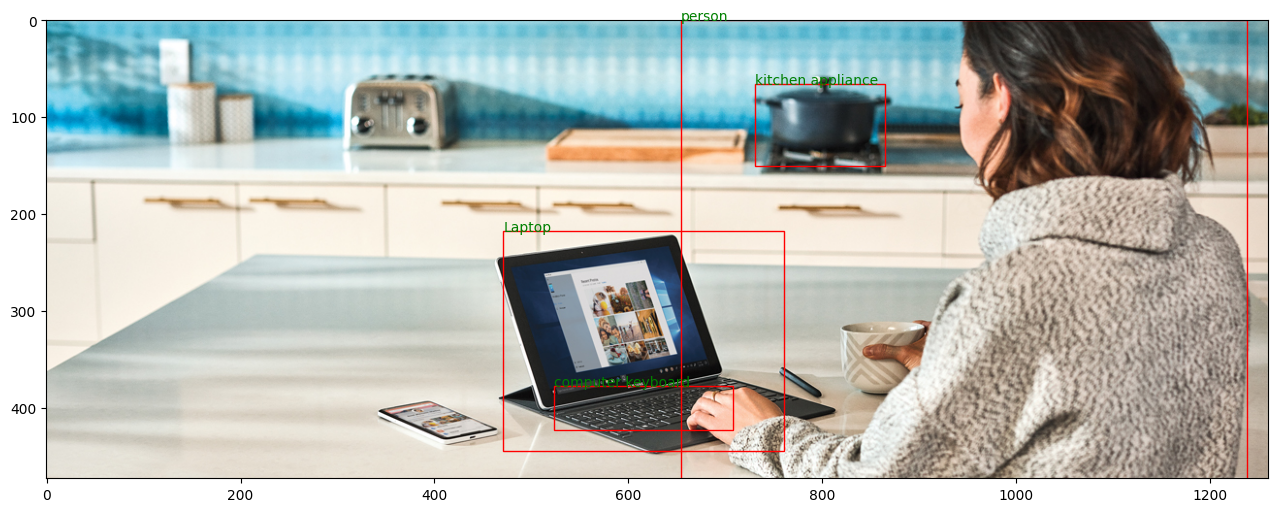

In [ ]:
fig, ax = plt.subplots(figsize=(473 / 30, 1260 / 30))

# Display the image
ax.imshow(img)

# Create a Rectangle patch
rect = []
for t in object_dict['objects']:
    rectangle = t['rectangle']
    x = rectangle['x']
    y = rectangle['y']
    w = rectangle['w']
    h = rectangle['h']
    obj=t['object']
    rect.append((x, y, w, h, obj))

# Add the patch to the Axes
for r in rect:
    x, y, w, h = r[:4]

    ax.add_patch(
        patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
    )
    plt.annotate(r[-1], (x, y), color='green')

plt.show()

In [ ]:
sobel_x = torch.Tensor([[1, 0, -1],
                        [2, 0, -2],
                        [1, 0, -1]])

sobel_y = torch.Tensor([[1, 2, 1],
                        [0, 0, 0],
                        [-1, -2, -1]])

In [ ]:
sobel_x = torch.cat((sobel_x, sobel_x, sobel_x)).reshape(3, 3, 3)

sobel_y = torch.cat((sobel_y, sobel_y, sobel_y)).reshape(3, 3, 3)

In [ ]:
sobel_x = torch.cat((sobel_x, sobel_x, sobel_x)).reshape(3, 3, 3, 3)

sobel_y = torch.cat((sobel_y, sobel_y, sobel_y)).reshape(3, 3, 3, 3)

In [ ]:
out_img_x = F.conv2d(torch.permute(torch.Tensor(img_array), (2, 0, 1)).unsqueeze(0), weight=sobel_x)
out_img_y = F.conv2d(torch.permute(torch.Tensor(img_array), (2, 0, 1)).unsqueeze(0), weight=sobel_y)

In [ ]:
out_img = torch.sqrt(torch.square(out_img_x) + torch.square(out_img_y))

In [ ]:
out_img /= torch.max(out_img)

In [ ]:
out_img = out_img.squeeze(0)

In [ ]:
out_img = torch.permute(out_img, (1, 2, 0))

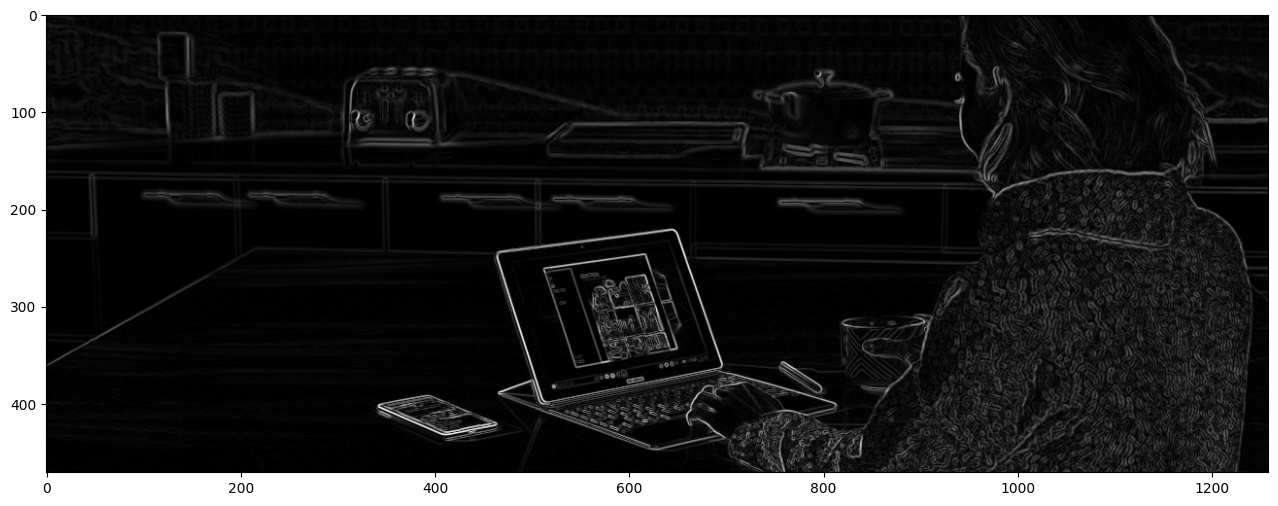

In [ ]:
plt.figure(figsize=(473 / 30, 1260 / 30))
plt.imshow(out_img.numpy())
plt.show()

## Datasets

We're going to quickly go over some of the datasets.
We're going to go over them in more detail later.

There are 4 datasets that arose out of the need for high quality annotated images to train neural networks:


1.   Caltech 101
1.   Pascal VOC
1.   MS COCO
1.   Objects 365.

Caltech 101 originated in 2003 by several researchers, Fei-Fei Li, Marco Andreetto, Marc'Aurelio Ranzato, and Pietro Perona, at the California Institute of Technology. Let's look at some examples.

In [ ]:
caltech101_ds = torchvision.datasets.Caltech101(root='./data', target_type='annotation', download=True)

Files already downloaded and verified


In [ ]:
caltech101_ds.annotation_categories

['Faces_2',
 'Faces_3',
 'Leopards',
 'Motorbikes_16',
 'accordion',
 'Airplanes_Side_2',
 'anchor',
 'ant',
 'barrel',
 'bass',
 'beaver',
 'binocular',
 'bonsai',
 'brain',
 'brontosaurus',
 'buddha',
 'butterfly',
 'camera',
 'cannon',
 'car_side',
 'ceiling_fan',
 'cellphone',
 'chair',
 'chandelier',
 'cougar_body',
 'cougar_face',
 'crab',
 'crayfish',
 'crocodile',
 'crocodile_head',
 'cup',
 'dalmatian',
 'dollar_bill',
 'dolphin',
 'dragonfly',
 'electric_guitar',
 'elephant',
 'emu',
 'euphonium',
 'ewer',
 'ferry',
 'flamingo',
 'flamingo_head',
 'garfield',
 'gerenuk',
 'gramophone',
 'grand_piano',
 'hawksbill',
 'headphone',
 'hedgehog',
 'helicopter',
 'ibis',
 'inline_skate',
 'joshua_tree',
 'kangaroo',
 'ketch',
 'lamp',
 'laptop',
 'llama',
 'lobster',
 'lotus',
 'mandolin',
 'mayfly',
 'menorah',
 'metronome',
 'minaret',
 'nautilus',
 'octopus',
 'okapi',
 'pagoda',
 'panda',
 'pigeon',
 'pizza',
 'platypus',
 'pyramid',
 'revolver',
 'rhino',
 'rooster',
 'saxopho

In [ ]:
def show_rand_image():
    num = torch.randint(low=0, high=8677, size=(1, )).item()

    image, label = caltech101_ds[num]

    plt.imshow(image)
    plt.plot(label[0, :], label[1, :])

    plt.show()

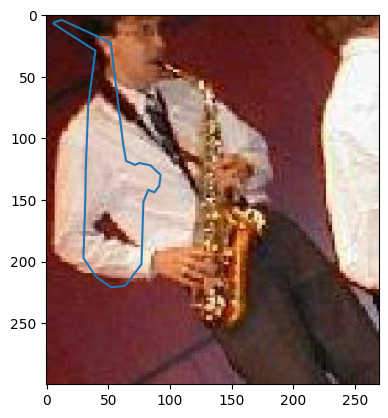

In [ ]:
show_rand_image()



```
%% show box
box_handle = rectangle('position', [box_coord(3), box_coord(1), box_coord(4)-box_coord(3), box_coord(2)-box_coord(1)]);
set(box_handle, 'edgecolor','y', 'linewidth',5);

%% show contour
for cc = 1:size(obj_contour,2)
   if cc < size(obj_contour,2)
      plot([obj_contour(1,cc), obj_contour(1,cc+1)]+box_coord(3), [obj_contour(2,cc), obj_contour(2,cc+1)]+box_coord(1), 'r','linewidth',4);
   else
      plot([obj_contour(1,cc), obj_contour(1,1)]+box_coord(3), [obj_contour(2,cc), obj_contour(2,1)]+box_coord(1), 'r','linewidth',4);
   end
end
```



In [ ]:
num = torch.randint(low=0, high=8677, size=(1, )).item()
print(num)

805


In [ ]:
root = './data/caltech101'

In [ ]:
categories = sorted(os.listdir(os.path.join(root, "101_ObjectCategories")))
categories.remove("BACKGROUND_Google")  # this is not a real class

In [ ]:
name_map = {
            "Faces": "Faces_2",
            "Faces_easy": "Faces_3",
            "Motorbikes": "Motorbikes_16",
            "airplanes": "Airplanes_Side_2",
        }

In [ ]:
annotation_categories = list(map(lambda x: name_map[x] if x in name_map else x, categories))

In [ ]:
index = []
y = []
for (i, c) in enumerate(categories):
    n = len(os.listdir(os.path.join(root, "101_ObjectCategories", c)))
    index.extend(range(1, n + 1))
    y.extend(n * [i])

In [ ]:
target_type = ['annotation']

In [ ]:
import scipy.io

img = Image.open(
    os.path.join(
        root,
        "101_ObjectCategories",
        categories[y[num]],
        f"image_{index[num]:04d}.jpg",
    )
)

target = []
for t in target_type:
    if t == "category":
        target.append(y[num])
    elif t == "annotation":
        data = scipy.io.loadmat(
            os.path.join(
                root,
                "Annotations",
                annotation_categories[y[num]],
                f"annotation_{index[num]:04d}.mat",
            )
        )
        target.append(data["obj_contour"])
target = tuple(target) if len(target) > 1 else target[0]

In [ ]:
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN, Created on: Thu Dec 02 11:46:09 2004',
 '__version__': '1.0',
 '__globals__': [],
 'box_coord': array([[  3, 260,  20, 239]], dtype=uint16),
 'obj_contour': array([[173.64210526, 171.37894737, 164.13684211, 151.91578947,
         133.81052632, 120.23157895, 104.38947368,  89.45263158,
          73.15789474,  64.55789474,  56.86315789,  52.78947368,
          47.81052632,  41.92631579,  37.4       ,  23.36842105,
           7.97894737,  12.95789474,  19.29473684,  36.49473684,
          52.78947368,  93.97894737, 108.91578947, 141.50526316,
         177.26315789, 193.55789474, 199.89473684, 203.96842105,
         199.44210526, 185.86315789, 174.09473684, 173.18947368],
        [168.2       , 195.35789474, 217.53684211, 235.64210526,
         245.6       , 251.48421053, 251.48421053, 242.43157895,
         225.68421053, 209.38947368, 184.04210526, 173.17894737,
         173.17894737, 157.33684211, 138.77894737, 125.65263158,
        

In [ ]:
y1, y2, x1, x2 = data['box_coord'][0]

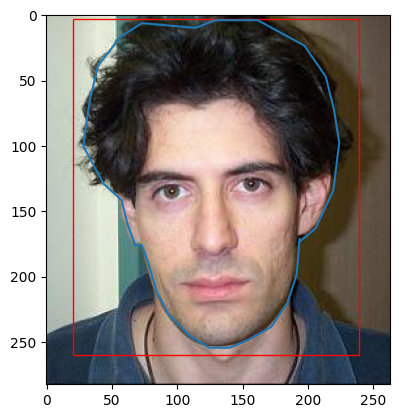

In [ ]:
fig, ax = plt.subplots()

# Display the image
ax.imshow(img)

# Create a Rectangle patch
# Add the patch to the Axes
plt.plot(target[0, :] + x1, target[1, :] + y1)

ax.add_patch(
    patches.Rectangle([x1, y1], width=x2-x1, height=y2-y1, linewidth=1, edgecolor='r', facecolor='none')
)


plt.show()

Let's look at Pascal VOC now.

In [ ]:
pascal_voc_ds = torchvision.datasets.VOCDetection(root='./data', download=True)

Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data


In [ ]:
num = torch.randint(low=0, high=len(pascal_voc_ds), size=(1, )).item()
print(num)

2532


In [ ]:
target['annotation']

{'filename': '2009_001615.jpg',
 'folder': 'VOC2012',
 'object': [{'name': 'tvmonitor',
   'bndbox': {'xmax': '180', 'xmin': '27', 'ymax': '336', 'ymin': '200'},
   'difficult': '0',
   'occluded': '1',
   'pose': 'Frontal',
   'truncated': '0'},
  {'name': 'person',
   'bndbox': {'xmax': '338', 'xmin': '200', 'ymax': '347', 'ymin': '100'},
   'difficult': '0',
   'occluded': '0',
   'pose': 'Unspecified',
   'truncated': '0'}],
 'segmented': '1',
 'size': {'depth': '3', 'height': '375', 'width': '500'},
 'source': {'annotation': 'PASCAL VOC2009',
  'database': 'The VOC2009 Database',
  'image': 'flickr'}}

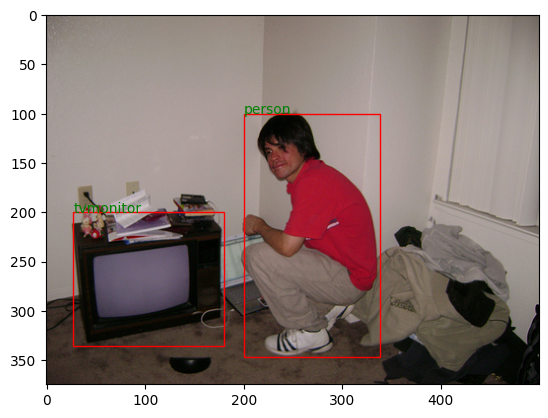

In [ ]:
fig, ax = plt.subplots()

# Display the image
ax.imshow(img)

annotations = target['annotation']['object']

# Create a Rectangle patch
rect = []
for t in annotations:
    rectangle = t['bndbox']
    xmin = int(rectangle['xmin'])
    ymin = int(rectangle['ymin'])
    xmax = int(rectangle['xmax'])
    ymax = int(rectangle['ymax'])
    x = xmin
    y = ymin
    w = xmax - xmin
    h = ymax - ymin
    obj=t['name']
    rect.append((x, y, w, h, obj))

# Add the patch to the Axes
for r in rect:
    x, y, w, h = r[:4]

    ax.add_patch(
        patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
    )
    plt.annotate(r[-1], (x, y), color='green')


plt.show()

We'll examine the COCO dataset

In [ ]:
!git clone https://github.com/cocodataset/cocoapi/

Cloning into 'cocoapi'...
remote: Enumerating objects: 975, done.
remote: Total 975 (delta 0), reused 0 (delta 0), pack-reused 975
Receiving objects: 100% (975/975), 11.72 MiB | 16.91 MiB/s, done.
Resolving deltas: 100% (576/576), done.


In [ ]:
!wget http://images.cocodataset.org/zips/val2017.zip

--2023-05-22 18:32:06--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.32.180, 3.5.28.23, 52.216.219.105, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.32.180|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  82.1MB/s    in 2m 33s  

2023-05-22 18:34:39 (5.08 MB/s) - ‘val2017.zip’ saved [815585330/815585330]



In [ ]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

--2023-05-22 18:38:05--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.2.1, 54.231.202.209, 54.231.169.121, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.2.1|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  84.8MB/s    in 2.8s    

2023-05-22 18:38:08 (84.8 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]



In [ ]:
!mkdir ./data/val2017/images
!mkdir ./data/val2017/annotations

In [ ]:
with zipfile.ZipFile("./val2017.zip","r") as zip_ref:
    zip_ref.extractall("./data/val2017/images")

with zipfile.ZipFile("annotations_trainval2017.zip","r") as zip_ref:
    zip_ref.extractall("./data/val2017/annotations")

In [ ]:
coco_ds = torchvision.datasets.CocoDetection(root='./data/val2017/images',
                                             annFile='./data/val2017/annotations/instances_val2017.json')

loading annotations into memory...
Done (t=1.42s)
creating index...
index created!


In [ ]:
import json

with open('./data/val2017/annotations/instances_val2017.json', 'r') as f:
    coco_cats = json.load(f)

In [ ]:
categories = [0] * 91

for c in coco_cats['categories']:
    categories[c['id']] = c['name']

In [ ]:
image, label = coco_ds[0]

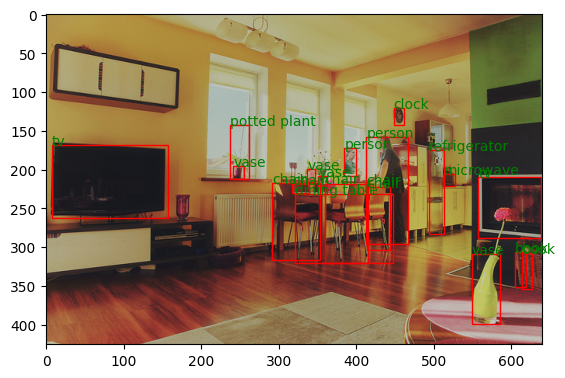

In [ ]:
fig, ax = plt.subplots()

# Display the image
ax.imshow(image)

# Create a Rectangle patch
rect = []
for t in label:
    rectangle = t['bbox']
    x, y, w, h = rectangle
    obj = t['category_id']
    rect.append((x, y, w, h, obj))

# Add the patch to the Axes
for r in rect:
    x, y, w, h = r[:4]

    ax.add_patch(
        patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
    )
    plt.annotate(categories[r[-1]], (x, y), color='green')


plt.show()